##carregando bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy.stats as scs

In [ ]:
#importando/lendo o arquivo a ser trabalhado com o pandas
mlcardio = pd.read_csv('/content/cardio_train.csv',sep=';')
mlcardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [ ]:
#excluindo a coluna id
mlcardio = mlcardio.drop(['id'],axis = 1)
#verificando algumas informações
mlcardio.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#alterando as idades de dias para anos aproximadamente
idade = mlcardio['age']
anos = (idade/365).round()
anos = anos.astype('int64')
mlcardio['age'] = anos
mlcardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,48,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
#calculando o IMC e adicionando ele a base
IMC = (mlcardio['weight']/(mlcardio['height']/100)**2)
IMC = pd.DataFrame(IMC)
mlcardio['IMC'] = IMC.round()
mlcardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC
0,50,2,168,62.0,110,80,1,1,0,0,1,0,22.0
1,55,1,156,85.0,140,90,3,1,0,0,1,1,35.0
2,52,1,165,64.0,130,70,3,1,0,0,0,1,24.0
3,48,2,169,82.0,150,100,1,1,0,0,1,1,29.0
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.0


In [ ]:
#colocando como 'valor faltante' nos outliers, pois há algumas inconsistencias nos extremos
#criando uma função que irá fazer isso:
def exclui_outliers(mlcardio, col_name):
  intervalo = 2*mlcardio[col_name].std()
  media = mlcardio[col_name].mean()
  mlcardio.loc[mlcardio[col_name] < (media - intervalo), col_name] = np.nan
  mlcardio.loc[mlcardio[col_name] > (media + intervalo), col_name] = np.nan

In [ ]:
#executando a função nas colunas onde havia erros perceptiveis nos outiliers
numerical_cols = ['height','weight','ap_hi','ap_lo','IMC']
for col in numerical_cols:
  exclui_outliers(mlcardio, col)

In [ ]:
#como é possível notar valores negativos foram retirados e valores extremamente altos também
mlcardio.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC
count,70000.000000,70000.000000,67665.000000,66765.000000,69962.000000,69047.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,67868.000000
mean,53.338686,1.349571,164.254253,72.753454,126.687616,81.322910,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,26.992721
std,6.765294,0.476838,7.078554,11.711464,18.247836,9.923572,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,4.419406
min,30.000000,1.000000,148.000000,45.800000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,16.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,24.000000
50%,54.000000,1.000000,165.000000,71.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.000000
75%,58.000000,2.000000,169.000000,80.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.000000
max,65.000000,2.000000,180.000000,102.000000,401.000000,190.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,39.000000


In [ ]:
#porém como a função substitui esses utilier por valores faltantes é possível ver que agora eles aparecem na nossa base

mlcardio.isna().sum()


age               0
gender            0
height         2335
weight         3235
ap_hi            38
ap_lo           953
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
cardio            0
IMC            2132
dtype: int64

In [ ]:
mlcardio.shape

(63433, 16)

In [ ]:
# e para trabalhar com os algoritmos de machine learning temos que retira-los
mlcardio.dropna(axis = 0, inplace = True)

In [ ]:
mlcardio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63433 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          63433 non-null  int64  
 1   gender       63433 non-null  int64  
 2   height       63433 non-null  float64
 3   weight       63433 non-null  float64
 4   ap_hi        63433 non-null  float64
 5   ap_lo        63433 non-null  float64
 6   cholesterol  63433 non-null  int64  
 7   gluc         63433 non-null  int64  
 8   smoke        63433 non-null  int64  
 9   alco         63433 non-null  int64  
 10  active       63433 non-null  int64  
 11  cardio       63433 non-null  int64  
 12  IMC          63433 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 6.8 MB


In [ ]:
#há variáveis qe são categóricas e estão aparecendo como inteiras,logo mudaremos os tipos delas para string
mlcardio[['gender','cholesterol',	'gluc',	'smoke',	'alco',	'active'	]] = mlcardio[['gender','cholesterol',	'gluc',	'smoke',	'alco',	'active'	]].astype(str)
mlcardio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63433 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          63433 non-null  int64  
 1   gender       63433 non-null  object 
 2   height       63433 non-null  float64
 3   weight       63433 non-null  float64
 4   ap_hi        63433 non-null  float64
 5   ap_lo        63433 non-null  float64
 6   cholesterol  63433 non-null  object 
 7   gluc         63433 non-null  object 
 8   smoke        63433 non-null  object 
 9   alco         63433 non-null  object 
 10  active       63433 non-null  object 
 11  cardio       63433 non-null  int64  
 12  IMC          63433 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 6.8+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


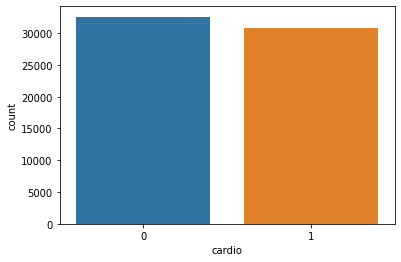

In [ ]:
#vizualização iniciall de quem tem problema cardiaco(1) e quem não tem no nosso conjunto de dados(0)
sns.countplot('cardio',data=mlcardio)

In [ ]:
#pandas.get_dummies () é usado para manipulação de dados. Ele converte dados categóricos em variáveis ​​fictícias ou indicadoras
mlcardio=pd.get_dummies(mlcardio)

In [ ]:
mlcardio

,age,height,weight,ap_hi,ap_lo,cardio,IMC,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,smoke_0,smoke_1,alco_0,alco_1,active_0,active_1
0,50,168.0,62.0,110.0,80.0,0,22.0,0,1,1,0,0,1,0,0,1,0,1,0,0,1
1,55,156.0,85.0,140.0,90.0,1,35.0,1,0,0,0,1,1,0,0,1,0,1,0,0,1
2,52,165.0,64.0,130.0,70.0,1,24.0,1,0,0,0,1,1,0,0,1,0,1,0,1,0
3,48,169.0,82.0,150.0,100.0,1,29.0,0,1,1,0,0,1,0,0,1,0,1,0,0,1
4,48,156.0,56.0,100.0,60.0,0,23.0,1,0,1,0,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,54,172.0,70.0,130.0,90.0,1,24.0,1,0,1,0,0,1,0,0,1,0,1,0,0,1
69994,58,165.0,80.0,150.0,80.0,1,29.0,1,0,1,0,0,1,0,0,1,0,1,0,0,1
69995,53,168.0,76.0,120.0,80.0,0,27.0,0,1,1,0,0,1,0,0,0,1,1,0,0,1
69998,61,163.0,72.0,135.0,80.0,1,27.0,1,0,1,0,0,0,1,0,1,0,1,0,1,0


In [ ]:
mlcardio = mlcardio.drop(['cholesterol_3','gluc_3','smoke_0','alco_0','active_0'],axis = 1)

In [ ]:
X = mlcardio.drop(['cardio'], axis=1)
y = mlcardio.cardio

In [ ]:
X.head()

,age,height,weight,ap_hi,ap_lo,IMC,gender_1,gender_2,cholesterol_1,cholesterol_2,gluc_1,gluc_2,smoke_1,alco_1,active_1
0,50,168.0,62.0,110.0,80.0,22.0,0,1,1,0,1,0,0,0,1
1,55,156.0,85.0,140.0,90.0,35.0,1,0,0,0,1,0,0,0,1
2,52,165.0,64.0,130.0,70.0,24.0,1,0,0,0,1,0,0,0,0
3,48,169.0,82.0,150.0,100.0,29.0,0,1,1,0,1,0,0,0,1
4,48,156.0,56.0,100.0,60.0,23.0,1,0,1,0,1,0,0,0,0


In [ ]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: cardio, dtype: int64

In [ ]:
#normalizar os dados - colocar na mesma escala ou limitar os dados
X = (X - X.min())/(X.max()-X.min())
X.head(10)

,age,height,weight,ap_hi,ap_lo,IMC,gender_1,gender_2,cholesterol_1,cholesterol_2,gluc_1,gluc_2,smoke_1,alco_1,active_1
0,0.571429,0.62500,0.288256,0.471869,0.576923,0.260870,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.714286,0.25000,0.697509,0.526316,0.615385,0.826087,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.628571,0.53125,0.323843,0.508167,0.538462,0.347826,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.514286,0.65625,0.644128,0.544465,0.653846,0.565217,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.514286,0.25000,0.181495,0.453721,0.500000,0.304348,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.857143,0.09375,0.377224,0.490018,0.576923,0.565217,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,0.885714,0.28125,0.839858,0.508167,0.576923,0.956522,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,0.914286,0.93750,0.875445,0.508167,0.615385,0.608696,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.514286,0.31250,0.448399,0.471869,0.538462,0.521739,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
9,0.685714,0.50000,0.395018,0.471869,0.500000,0.391304,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=5)

##Regressão logística

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
lr.predict_proba(X_test)

array([[0.64037718, 0.35962282],
       [0.41523547, 0.58476453],
       [0.57794793, 0.42205207],
       ...,
       [0.58257834, 0.41742166],
       [0.42335861, 0.57664139],
       [0.72703181, 0.27296819]])

In [ ]:
y_pred

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
print(accuracy_score(y_test,y_pred)*100,'%')

71.94847311053059 %


In [ ]:
dic = {1:'positivo',0:'negativo'}

Text(0.5, 1.0, 'Matriz de confusão na ordem de 10³ \n')

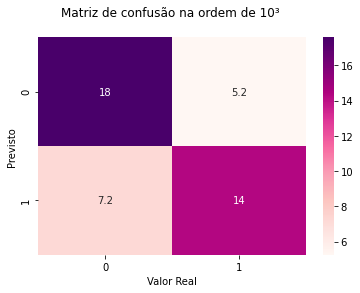

In [ ]:
ax = sns.heatmap(confusion_matrix(y_test,y_pred)/1000, annot=True, cmap="RdPu")
plt.ylabel('Previsto')
plt.xlabel('Valor Real')
plt.title('Matriz de confusão na ordem de 10³ \n')

In [ ]:
confusao = confusion_matrix(y_test,y_pred)
confusao

array([[17592,  5248],
       [ 7208, 14356]])

In [ ]:
#calculando o odds ration
odds = np.exp(lr.coef_)

In [ ]:
for i in range(0, len(X.columns)):
    print(X.columns[i],":",odds[0][i])

age : 7.125339990386371
height : 0.7455892767485288
weight : 2.6659566869389923
ap_hi : 14020426.500404831
ap_lo : 1710.2013498359843
IMC : 0.9749044861212912
gender_1 : 0.9483068348259195
gender_2 : 0.9902219902558347
cholesterol_1 : 0.31843641950268414
cholesterol_2 : 0.4874194713213166
gluc_1 : 1.3569777715524856
gluc_2 : 1.4206610129292279
smoke_1 : 0.8493053647983937
alco_1 : 0.7943396422212677
active_1 : 0.7766302247393131


##Random Forest

In [ ]:
#Random Forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_predic=clf.predict(X_test)


In [ ]:
print(accuracy_score(y_test,y_predic)*100)

70.85397711917845


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

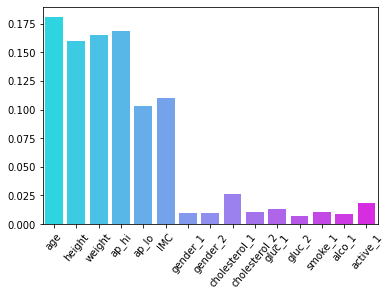

In [ ]:
sns.barplot(x=X.columns, y=clf.feature_importances_,palette='cool')
plt.xticks(rotation=50)

Text(0.5, 15.0, 'Valor Real')

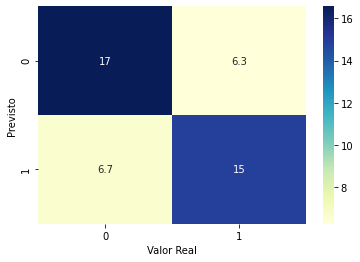

In [ ]:
ax = sns.heatmap(confusion_matrix(y_test,y_predic)/1000, annot=True, cmap="YlGnBu")
plt.ylabel('Previsto')
plt.xlabel('Valor Real')

##SMV

In [ ]:
#SVM
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train,y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_predicao=clf.predict(X_test)

In [ ]:
print(accuracy_score(y_test,y_predicao)*100)

71.185028375822


Text(0.5, 1.0, 'Matriz de confusão na ordem de 10³ \n')

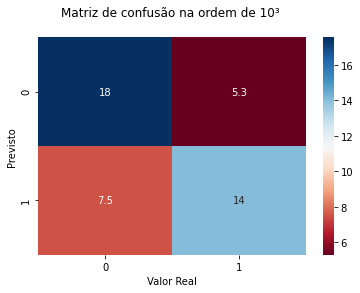

In [ ]:
ax = sns.heatmap(confusion_matrix(y_test,y_predicao)/1000, annot=True, cmap="RdBu")
plt.ylabel('Previsto')
plt.xlabel('Valor Real')
plt.title('Matriz de confusão na ordem de 10³ \n')